In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import random
from tqdm import tqdm
from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.transform import resize
import matplotlib.pyplot as plt
from load_data import load_path, tf_data, tf_classification, get_np_images

print(tf.version.VERSION)

2.3.0


In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Defining parameters

h = 256
w = 256
channels = 3
batch_size = 8
buffer_size = 200
num_epochs = 20
lr = 1e-3
seed = 42
np.random.seed = seed

In [4]:
train_path_hr='Datasets/HYPERTENSION/HR_aug/train'
train_path_nhr='Datasets/HYPERTENSION/HR_aug/train_nonhr'
test_path_hr='Datasets/HYPERTENSION/HR_aug/val'
test_path_nhr='Datasets/HYPERTENSION/HR_aug/val_nonhr'

X_train_hr, X_train_nhr = load_path(train_path_hr, train_path_nhr)
X_test_hr, X_test_nhr = load_path(test_path_hr, test_path_nhr)

Y_train_hr = np.ones(len(X_train_hr))
Y_train_nhr = np.zeros(len(X_train_nhr))
Y_test_hr = np.ones(len(X_test_hr))
Y_test_nhr = np.zeros(len(X_test_nhr))

In [5]:
X_train = X_train_hr + X_train_nhr
Y_train = np.concatenate((Y_train_hr, Y_train_nhr), axis = None)
Y_train = Y_train[:, None]
X_test = X_test_hr + X_test_nhr
Y_test = np.concatenate((Y_test_hr, Y_test_nhr), axis = None)
Y_test = Y_test[:, None]

In [6]:
Train = tf_classification(X_train, Y_train, buffer_size, batch_size, num_epochs)
Test = tf_classification(X_test, Y_test, buffer_size, batch_size, num_epochs)

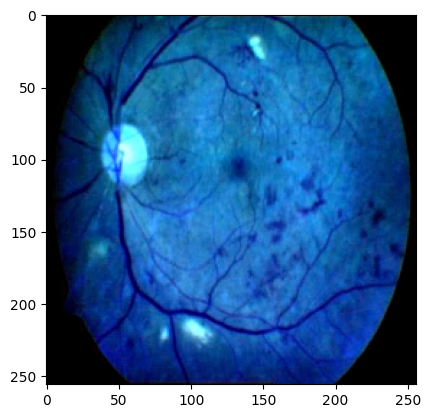

tf.Tensor([1.], shape=(1,), dtype=float32)


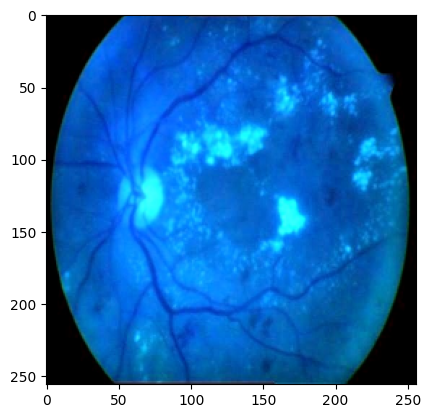

tf.Tensor([1.], shape=(1,), dtype=float32)


In [7]:
for x, y in Train:
    plt.imshow(x[1]);
    plt.show();
    print(y[1])
    break
    
for x, y in Test:
    plt.imshow(x[1]);
    plt.show();
    print(y[1])
    break

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

In [9]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.applications.xception import Xception
from tensorflow.keras.regularizers import l2

In [10]:
xcep_model = Xception(weights = 'imagenet', include_top = False)
x = xcep_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(100, activation = 'relu')(x)
predictions = Dense(1, activation = 'sigmoid')(x)
model = Model(inputs = xcep_model.input, outputs = predictions)

In [11]:
for layer in xcep_model.layers:
    layer.trainable = False

In [12]:
train_steps = len(X_train)//batch_size
test_steps = len(X_test)//batch_size
if len(X_train) % batch_size != 0:
    train_steps += 1
if len(X_test) % batch_size != 0:
    test_steps += 1

input_shape = (h, w, 3)
model.compile(optimizer = Adam(lr), loss = 'binary_crossentropy', metrics = ['accuracy', Recall(), Precision()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [13]:
#Model Checkpoint
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_retina', verbose = 1, save_best_only = True)

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience = 50, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs'),
]

results=model.fit(
    Train,
    validation_data = Test, 
    batch_size = batch_size, 
    steps_per_epoch = train_steps,
    validation_steps = test_steps,
    epochs = num_epochs, 
    callbacks=callbacks)

Epoch 1/20
  1/202 [..............................] - ETA: 0s - loss: 1.0349 - accuracy: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00WARNING:tensorflow:From C:\Users\User\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
202/202 [==============================] - 65s 324ms/step - loss: 0.2089 - accuracy: 0.9461 - recall: 0.9363 - precision: 0.9042 - val_loss: 0.0994 - val_accuracy: 0.9725 - val_recall: 0.9559 - val_precision: 0.9512
Epoch 2/20
202/202 [==============================] - 56s 279ms/step - loss: 0.0710 - accuracy: 0.9820 - recall: 0.9775 - precision: 0.9685 - val_loss: 0.0686 - val_accuracy: 0.9783 - val_recall: 0.9559 - val_precision: 0.9701
Epoch 3/20
202/202 [==============================] - 56s 275ms/step - loss: 0.0542 - accuracy: 0.9789 - recall: 0.9682

In [15]:
# from load_data import read_image

# for i in range(len(X_test)):
#     x = read_image(X_test[i])
#     y_pred = model.predict(np.expand_dims(x, axis = 0))
#     print((y_pred>=0.5)==Y_test[i])
print('Train result: ')
results = model.evaluate(Train, batch_size = 128)
print('Test result: ')
results = model.evaluate(Test, batch_size = 128)

Train result: 
4040/4040 [==============================] - 782s 194ms/step - loss: 5.6710e-05 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000
Test result: 
1740/1740 [==============================] - 365s 210ms/step - loss: 0.0488 - accuracy: 0.9884 - recall: 0.9853 - precision: 0.9757


In [16]:
model.save('HR.h5')